In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benig

In [2]:
base_dir = '/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration'

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

2025-07-26 18:29:54.941980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753554595.134695      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753554595.190962      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
batch_size = 32

train_datagen = ImageDataGenerator(
    validation_split = 0.2,
#    rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range = 30,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)#  rescale=1./255,

In [5]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'Train'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse', 
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir,'Test'),
    target_size = (224,224),
    batch_size = batch_size,
    class_mode='sparse'
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [6]:
images, labels = next(train_generator)
print(labels)

[3. 3. 3. 5. 5. 3. 3. 4. 4. 3. 4. 1. 4. 5. 1. 5. 7. 2. 7. 5. 7. 1. 0. 4.
 3. 1. 4. 1. 3. 6. 1. 5.]


In [7]:
images, labels = train_generator.__getitem__(0)
images.shape

(32, 224, 224, 3)

In [8]:
train_generator.class_indices

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [9]:
np.unique(train_generator.classes, return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 92, 301,  76, 351, 286, 370,  62, 145, 112]))

In [10]:
class_indices = train_generator.class_indices
classes = train_generator.classes
unique_classes,counts = np.unique(train_generator.classes, return_counts=True)

print(dict(zip(unique_classes,counts)))

{0: 92, 1: 301, 2: 76, 3: 351, 4: 286, 5: 370, 6: 62, 7: 145, 8: 112}


In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

#format required for model.fit() is dict so 
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 2.167874396135266, 1: 0.6626061277224068, 2: 2.624269005847953, 3: 0.5682177904400126, 4: 0.6973581973581974, 5: 0.539039039039039, 6: 3.216845878136201, 7: 1.3754789272030652, 8: 1.7807539682539681}


In [12]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1753554609.793575      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers :
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
    print(layer.name,layer.trainable)



input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [14]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [15]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())

model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=9,activation='softmax'))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,181,001 (80.80 MB)

 Trainable params: 13,545,737 (51.67 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'],)

In [18]:
history = model.fit(train_generator,epochs=26,class_weight=class_weight_dict,validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/26


I0000 00:00:1753554620.348200      82 service.cc:148] XLA service 0x7aaf3c014840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753554620.349189      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753554621.010417      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.1172 - loss: 4.4353  

I0000 00:00:1753554631.115407      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1459 - loss: 2.6840 - val_accuracy: 0.2140 - val_loss: 2.0938
Epoch 2/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 695ms/step - accuracy: 0.1940 - loss: 2.1585 - val_accuracy: 0.3446 - val_loss: 1.8672
Epoch 3/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 701ms/step - accuracy: 0.2527 - loss: 2.0531 - val_accuracy: 0.3243 - val_loss: 1.8498
Epoch 4/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 675ms/step - accuracy: 0.2977 - loss: 1.8016 - val_accuracy: 0.3874 - val_loss: 1.9620
Epoch 5/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 682ms/step - accuracy: 0.3027 - loss: 1.7598 - val_accuracy: 0.3423 - val_loss: 2.0682
Epoch 6/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 696ms/step - accuracy: 0.3206 - loss: 1.6786 - val_accuracy: 0.4369 - val_loss: 2.1071
Epoch 7/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 686ms/step - accuracy: 0.3461 - loss: 1.6137 - val_accuracy: 0.4685 - val_loss: 1.6033
Epoch 8/26
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 676ms/step - accuracy: 0.3782 - loss: 1.4871 - val_accuracy: 0.4392 -

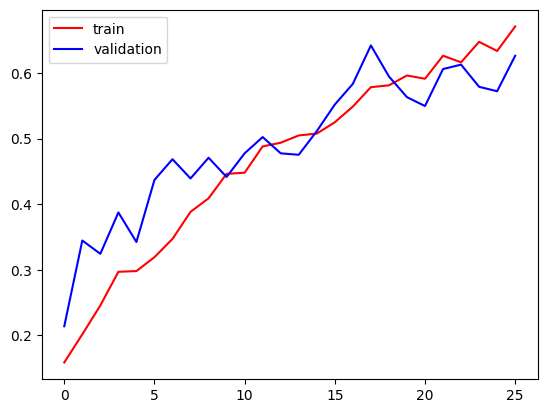

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

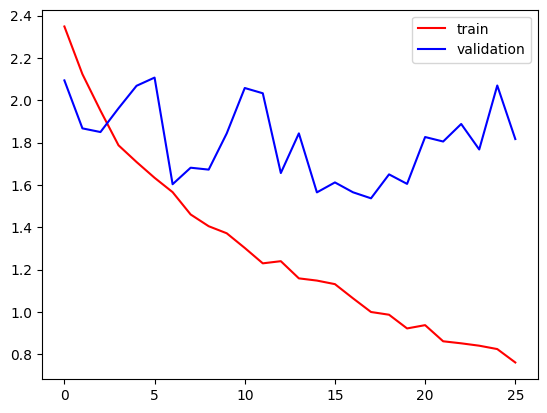

In [20]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [21]:
x_batch, y_true_batch = next(test_generator)
x_single = x_batch[2:3]  
y_true = y_true_batch[2]

In [22]:
y_pred_probs = model.predict(x_single)
y_pred_class = np.argmax(y_pred_probs, axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


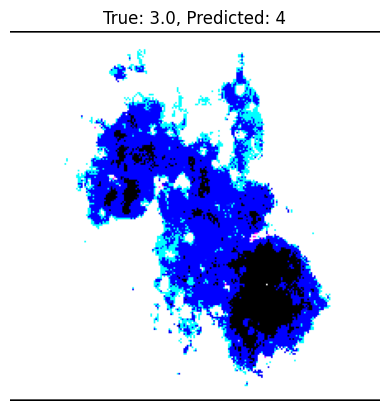

In [23]:
plt.imshow(x_single[0])  
plt.title(f"True: {y_true}, Predicted: {y_pred_class}")
plt.axis('off')
plt.show()


In [24]:
y_true = []
y_pred = []

for i in range (len(test_generator)):
    
        x_batch , y_batch = test_generator[i]
        y_class_prob = model.predict(x_batch)
        y_predict_class = np.argmax(y_class_prob,axis=1)
        y_pred.extend(y_predict_class )
        y_true.extend(y_batch)
        
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


[[ 5  0  1  0  1  7  1  1  0]
 [ 0 10  0  0  0  4  1  1  0]
 [ 0  1 10  3  0  1  0  1  0]
 [ 0  0  0  1 13  2  0  0  0]
 [ 0  0  0  0 12  4  0  0  0]
 [ 1  1  1  1  0 11  0  1  0]
 [ 0  0  0  2  0  0  1  0  0]
 [ 0  2  1  1  1  8  0  3  0]
 [ 0  0  0  0  0  0  0  0  3]]


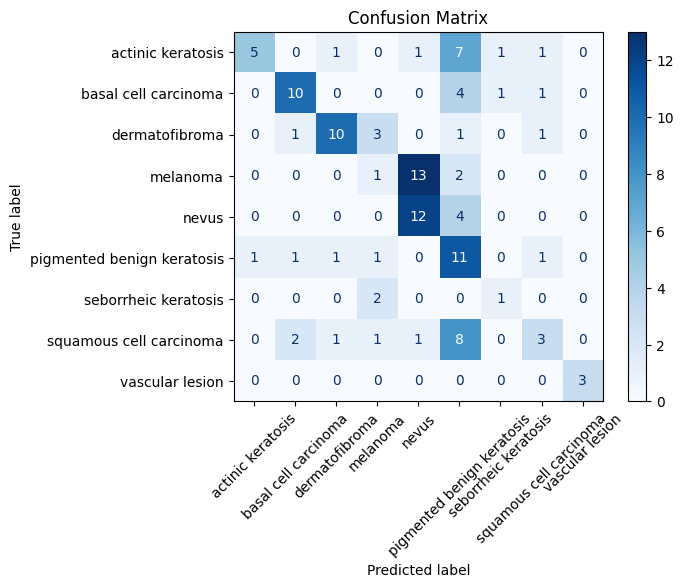

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [26]:
len(test_generator)

4